# Rover Homework

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Circle
from scipy.io import loadmat
from scipy.integrate import solve_ivp
import pickle
import os
import sympy as sp
from tqdm import tqdm
from pprint import pprint
from matplotlib import animation
from Library.load_maps import load_maps
from Library.get_indices import get_indices
from Library.obstacles_check import obstacles_check
from Library.kinematicModel import kinematicModel
from Library.move2pose import move2pose
from Library.pose2polar import pose2polar
from Library.polar2pose import polar2pose
from Library.A_star_without_reopening import A_star_without_reopening
from Library.EKF import EKF
from Library.dead_reckoning import dead_reckoning
from Library.dead_reckoning import plot_covariance_ellipse

# from rich.traceback import install
# install(show_locals = True)

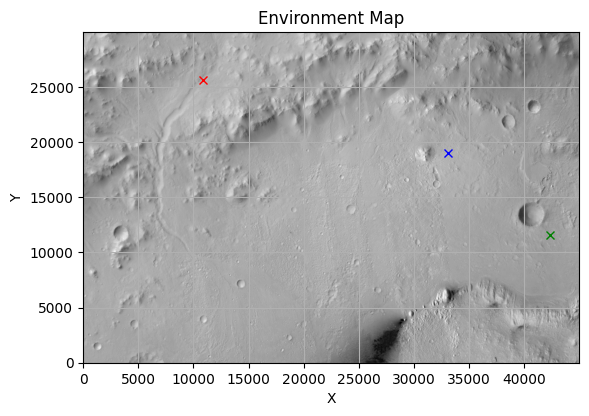

In [2]:
# Set Options
np.set_printoptions(floatmode='fixed', precision=2, suppress=True)


X, Y, env_map, obstacleMap, xLM, yLM, Xvec, Yvec = load_maps()

# Map Resolution
mapRes = 10     # meters per pixel

# Squeeze Xvec and Yvec -> both these variables must be one-dimensional vectors
Xvec = np.squeeze(Xvec)
Yvec = np.squeeze(Yvec)

# Define Physical Values
L = 3           # m - axles distance
v_max = 4e-2    # m/s - max speed

# Poses
Position0 = np.array([42380, 11590, np.pi/2])  # m, m, rad
Position1 = np.array([33070, 19010, np.pi])    # m, m, rad
Position2 = np.array([10870, 25670])    # m, m

# Show Environment Map
plt.figure("Environment Map")
plt.title("Environment Map")
# library.plot_map(map_image, Xvec, Yvec)
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.axis('on')
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')

# Plot on the environment map the starting position and the goal positions of the robot
plt.plot(Position0[0], Position0[1], 'gx', markersize=6)
plt.plot(Position1[0], Position1[1], 'bx', markersize=6)
plt.plot(Position2[0], Position2[1], 'rx', markersize=6)

plt.show()

# #NOT SURE THEY ARE NEEDED NOW
# # Show obstacle map
# plt.figure()
# plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

# # Show landmarks map
# plt.figure()
# plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
# plt.plot(xLM, yLM, 'yo', markersize=5, linewidth=2)
# plt.grid(True)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

**Find specific Landmarks**

In [ ]:
# xguess = 41000
# yguess = 16000
# tol = 1000
# counter = 0

# for xlm, ylm in zip(xLM, yLM):
    
#     if abs(xguess - xlm) < tol and abs(yguess - ylm) < tol:

#         counter += 1
#         break

# print(xlm == xLM)
# print(counter)
# print(xLM[0], yLM[0])

### Task 1: Navigation - Moving to a Pose MODIFY THIS

The first task requires the Rover to reach a first new pose using the Moving to a Pose control law.

The gains were selected as follows:
`K = [1e-4, 1.4e-3, -1.8e-3]`

In [3]:
# Compute Relative States
Polar0 = pose2polar(Position0, Position1)
Polar1 = pose2polar(Position1, Position1)

# Convert backwards the Relative State into Pose State
# Position0p = polar2pose(R0, Position1)

Position0_str = [f"{x:.2f}".ljust(10) for x in Position0]
Polar0_str = [f"{x:.2f}".ljust(10) for x in Polar0]
Polar1_str = [f"{x:.2f}".ljust(10) for x in Polar1]

print('\nThe Initial Pose State is:\n',' '.join(Position0_str))
print('\nThe Relative Pose State is:\n',' '.join(Polar0_str))
# print("\nThe Backconverted Initial Pose State is Position0':\n", Position0p)

# Event function
rho_tol = 0.1    # m
def event(t, R):
    return R[0] - rho_tol
event.terminal = True

# Time Domain
# Initial start time in seconds
t0 = 0 
# Maximum manoeuvre time -> 30 days in seconds
tf = 30 * 24 * 60**2
# Sampling frequency of the trajectory in Hz
freq = 0.01
# tspan generation at given sampling frequency
tspan = np.arange(t0, tf+1, 1/freq)


# Gains [Krho Kalpha Kbeta]
K = np.array([1e-1, 1.48e-3, -1.8999e-3])

# Solve the differential equation
sol = solve_ivp(lambda t, R: kinematicModel(t, R, K), [t0, tf], Polar0, method='RK45', t_eval=tspan, events=event)
tspan = sol.t
R = sol.y
P = polar2pose(R, Position1)

# Check for Obstacles
P_indices = np.array([get_indices(P[0:2, i], X, Y, mapRes) for i in range(P.shape[1])])    # convert each point in the trajectory to map indices
if obstacles_check(P_indices, obstacleMap):
    print('\n\nThe Trajectory intersects with an Obstacle!\n\n')

Position1r = P[:, -1]      # store the real final state of the robot for the next task



The Initial Pose State is:
 42380.00   11590.00   1.57      

The Relative Pose State is:
 11905.15   0.90       0.67      


The Dysplay of the results

In [4]:
# Convert the numbers to strings with a certain width and 2 decimal places just for display purposes
Position0_str = [f"{x:.2f}".ljust(10) for x in Position0]
P_final_str = [f"{x:.2f}".ljust(10) for x in P[:, -1]]
Position1_str = [f"{x:.2f}".ljust(10) for x in Position1]
error_str = [f"{x:.2f}".ljust(10) for x in P[:, -1] - Position1]

# Log Results
print('Initial state:\t', ' '.join(Position0_str), 'm, m, rad')
print('Final state is:\t', ' '.join(P_final_str), 'm, m, rad')
print('Desired state:\t', ' '.join(Position1_str), 'm, m, rad')
print('\nError:\t', ' '.join(error_str), 'm, m, rad')
print('Final Time: {:.2f} seconds\n'.format(tspan[-1]),'equal to: {:.2f} days'.format(tspan[-1]/ (24 * 60**2)))

Initial state:	 42380.00   11590.00   1.57       m, m, rad
Final state is:	 33071.74   19010.00   3.14       m, m, rad
Desired state:	 33070.00   19010.00   3.14       m, m, rad

Error:	 1.74       -0.00      0.00       m, m, rad
Final Time: 331600.00 seconds
 equal to: 3.84 days


The plot of the trajectory in the environment map

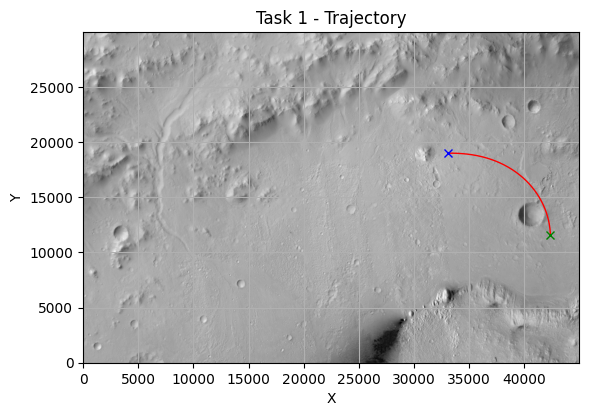

In [5]:
# Environment map with trajectory
plt.figure("Task 1 - Trajectory")
plt.title("Task 1 - Trajectory")
# library.plot_map(env_map, Xvec, Yvec)
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.axis('on')
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(P[0, :], P[1, :], 'r', linestyle='-', linewidth=1)
plt.plot(Position0[0], Position0[1], 'gx', markersize=6)
plt.plot(Position1[0], Position1[1], 'bx', markersize=6)

#TODO: Plot animation of the trajectory

plt.show()

The plot of the trajectory in the obstacle map in order to show that it doesn't collide with obstacles

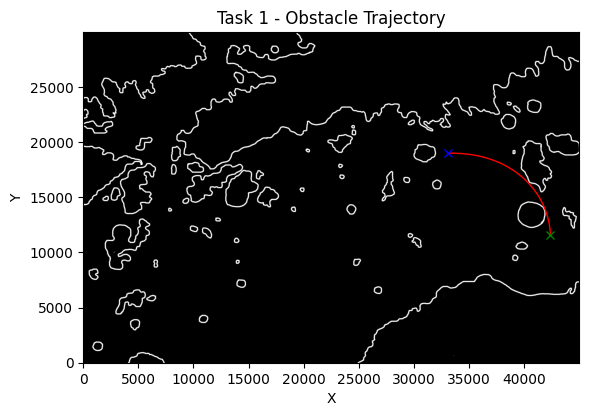

In [6]:
# Obstacle map with trajectory
plt.figure("Task 1 - Obstacle Trajectory")
plt.title("Task 1 - Obstacle Trajectory")
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(P[0, :], P[1, :], 'r', linestyle='-', linewidth=1)
plt.plot(Position0[0], Position0[1], 'gx', markersize=6)
plt.plot(Position1[0], Position1[1], 'bx', markersize=6)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Task 2: Path Planning - A* Algorithm

In [ ]:
# Start and Goal Coordinates
# the start is the stored value of the real final state of the robot from the previous task
A_star_start = Position1r[0:2]
# the goal is the previously defined Position2
A_star_goal = np.array([Position2[0], Position2[1]])

#convert the positions in map indices (pixels) since A* will need pixels to find a path
A_star_start = get_indices(A_star_start, X, Y, mapRes)
A_star_goal = get_indices(A_star_goal, X, Y, mapRes)

#display the values of the start and goal coordinates
print('Start indices:\t', A_star_start)
print('Goal indices:\t', A_star_goal)

# Obstacle map with start and goal coordinates
plt.figure("Obstacle map")
plt.title("Obstacle map")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start[1]], [A_star_start[0]], 'bx', markersize=6)
plt.plot([A_star_goal[1]], [A_star_goal[0]], 'rx', markersize=6)
plt.show()

#### Compute the path with A*

In [ ]:
# find the path using A* algorithm
path = A_star_without_reopening(A_star_start, A_star_goal, obstacleMap)          
# convert to matrix
path = np.array(path)

Plot the A* path

In [ ]:
np.save('path.npy', path)
print('The size of the retrieved path is:', path.size)
# Plot the Path
plt.figure("Task 2 - Pathfinding")
plt.title("Task 2 - A* Path")
plt.imshow(obstacleMap, cmap='gray')
plt.plot([A_star_start[1]], [A_star_start[0]], 'bx', markersize=6)
plt.plot([A_star_goal[1]], [A_star_goal[0]], 'rx', markersize=6)
plt.plot(path[:, 1], path[:, 0], c='yellow', linestyle='-', linewidth=1)

plt.show()

### Task 3: Rover Localization

Define Problem Parameters

In [65]:
# Retrieve Trajectory from Task 1
q_real = P.T            # N x 3 matrix containing the real pose state at each time step
tspan_real = tspan      # N x 1 array containing the timespan
# print(q_real)

# Define Model Parameters
sigma_x = 6                         # m
sigma_y = 6                         # m
sigma_theta = np.deg2rad(1)         # rad

# Define Initial Covariance Matrix
L0 = np.array([[sigma_x**2, 0, 0], [0, sigma_y**2, 0], [0, 0, sigma_theta**2]])

# Define Sensor Parameters
sigma_d = 0.004      # m         #odometer distance measurement noise
sigma_theta = np.deg2rad(0.05)      # rad       #odomter heading angle measurement noise

lidar_maxrange=500      #m         # lidar maximum range
sigma_r=0.010       # m         # lidar range measurement noise
sigma_beta=np.deg2rad(0.25)     #rad     # lidar bearing measurement noise


Perform Dead Reckoning

In [73]:
q_est_dr, L_est_dr = dead_reckoning(q_real, sigma_d, sigma_theta, L0)

sqrt_det_L_dr = [np.sqrt(np.linalg.det(L_dr)) for L_dr in L_est_dr]

Processing: 100%|██████████| 3316/3316 [00:00<00:00, 56755.42it/s]


Plot of the Path

/var/folders/37/01jbqlss0p17nl4wt33b73wh0000gn/T/ipykernel_1932/3237206061.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


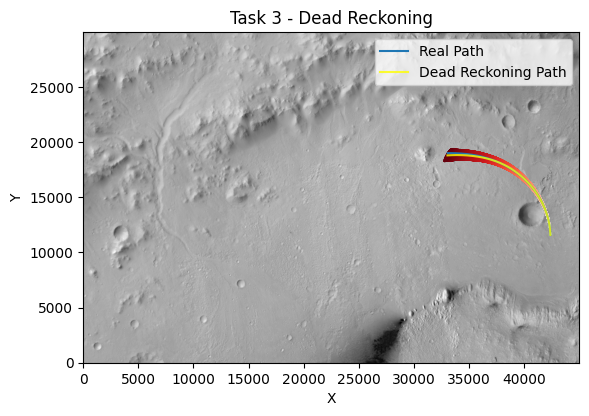

In [87]:
plt.figure("Task 3 - Dead Reckoning")
plt.title("Task 3 - Dead Reckoning")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path')
plt.plot(q_est_dr[:, 0], q_est_dr[:, 1], label='Dead Reckoning Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Get a colormap
cmap = cm.get_cmap('Reds')
# Calculate the number of ellipses
num_ellipses = len(q_est_dr)
for i in range(num_ellipses):
    # Get a color from the colormap
    color = cmap(i / num_ellipses)
    # Plot the ellipse with the chosen color
    plot_covariance_ellipse(q_est_dr[i, :2], L_est_dr[i], plt, n_sigma=3, edgecolor=color, alpha=0.8)

plt.show()

To show that avoids slope regions

/var/folders/37/01jbqlss0p17nl4wt33b73wh0000gn/T/ipykernel_1932/3238200195.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


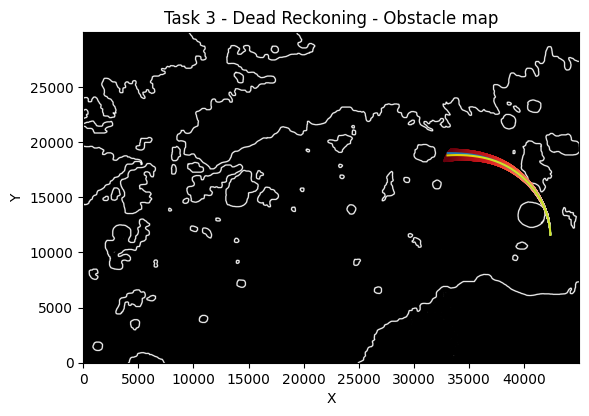

In [88]:
plt.figure("Task 3 - Dead Reckoning - Obstacle map")
plt.title("Task 3 - Dead Reckoning - Obstacle map")
plt.imshow(obstacleMap, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path')
plt.plot(q_est_dr[:, 0], q_est_dr[:, 1], label='Dead Reckoning Path', c='yellow', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')

# Get a colormap
cmap = cm.get_cmap('Reds')
# Calculate the number of ellipses
num_ellipses = len(q_est_dr)
for i in range(num_ellipses):
    # Get a color from the colormap
    color = cmap(i / num_ellipses)
    # Plot the ellipse with the chosen color
    plot_covariance_ellipse(q_est_dr[i, :2], L_est_dr[i], plt, n_sigma=3, edgecolor=color, alpha=0.8)


plt.show()

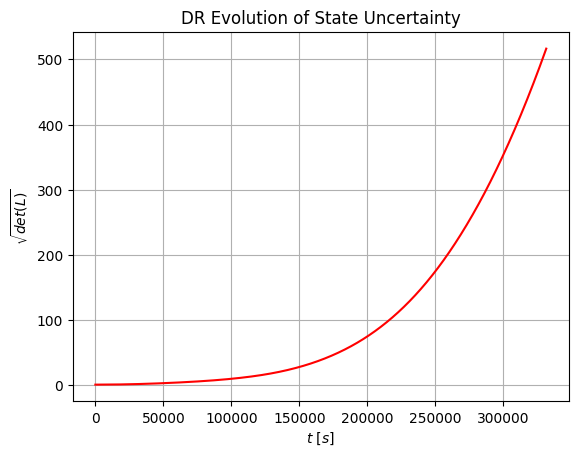

In [76]:
# Visualize the Covariance Matrix Evolution
plt.figure("DR Covariance Matrix Evolution")
plt.plot(tspan, sqrt_det_L_dr, c='red')
plt.xlabel('$t \ [s]$')
plt.ylabel('$\sqrt{det(L)}$')
plt.title('DR Evolution of State Uncertainty')
plt.grid(True)
plt.show()

Define Observable Functions

$z = h(q, lm) \qquad \qquad H_q = \frac{\partial h}{\partial q}$

Perform the Trajectory Reconstruction

In [16]:
# Compute Reconstructed Trajectory
q_est, L_est = EKF(q_real, sigma_d, sigma_theta, L0, lidar_maxrange, sigma_r, sigma_beta, xLM, yLM)

# Compute the square root of the determinant of each Covariance matrix
sqrt_det_L = [np.sqrt(np.linalg.det(L)) for L in L_est]


Processing: 100%|██████████| 3316/3316 [00:00<00:00, 3861.31it/s]


Plot the estimated trajectory

/var/folders/37/01jbqlss0p17nl4wt33b73wh0000gn/T/ipykernel_1932/980378899.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


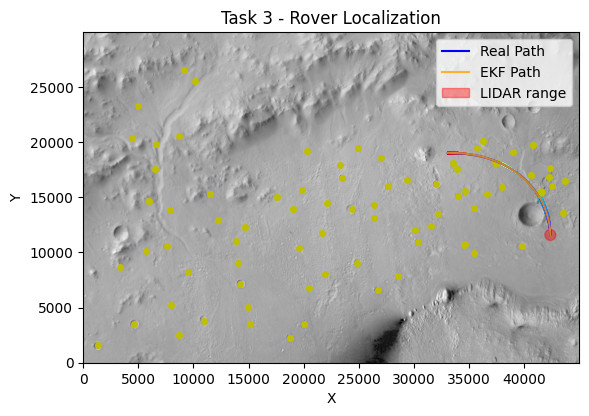

In [89]:
plt.figure("Task 3 - Rover Localization")
plt.title("Task 3 - Rover Localization")
plt.imshow(env_map, cmap='gray', extent=(Xvec[0], Xvec[-1], Yvec[-1], Yvec[0]))
plt.plot(xLM, yLM, 'yo', markersize=4, linewidth=1)
plt.plot(xLM[12], yLM[12], 'yo', markersize=5, linewidth=2)
plt.plot(xLM[0], yLM[0], 'yo', markersize=5, linewidth=2)
plt.plot(q_real[:, 0], q_real[:, 1], label='Real Path', c='Blue')
plt.plot(q_est[:, 0], q_est[:, 1], label='EKF Path', c='orange', linestyle='-', alpha= 0.8)
plt.xlabel('X')
plt.ylabel('Y')

#sow a circle of the radius of the lidar range
circle = Circle((q_est[0, 0], q_est[0, 1]), lidar_maxrange, label='LIDAR range', color='r', fill=True, alpha=0.4)
plt.gca().add_patch(circle)
plt.legend()

# Get a colormap
cmap = cm.get_cmap('rainbow')
# Calculate the number of ellipses
num_ellipses = len(q_est)
for i in range(num_ellipses):
    # Get a color from the colormap
    color = cmap(i / num_ellipses)
    # Plot the ellipse with the chosen color
    plot_covariance_ellipse(q_est[i, :2], L_est[i], plt, n_sigma=4, edgecolor=color, alpha=1)
plt.show()

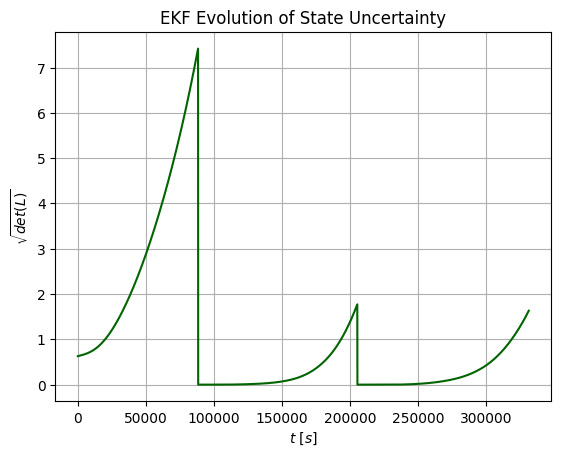

In [78]:
# Visualize the Covariance Matrix Evolution
plt.figure("EKF Covariance Matrix Evolution")
plt.plot(tspan, sqrt_det_L, c='darkgreen')
plt.xlabel('$t \ [s]$')
plt.ylabel('$\sqrt{det(L)}$')
plt.title('EKF Evolution of State Uncertainty')
plt.grid(True)
plt.show()
